## 通过神经网络预测房价
在这个项目中，我们希望能够构建神经网络来预测房屋的价格

首先，我们导入一些必要的库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

%matplotlib inline
%load_ext autoreload
%autoreload 2

读取训练集和测试集的数据

In [2]:
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')

可以具体看看前面 5 个训练集长什么样子，可以看到，前面都是这个房屋的属性，最后是房屋的价格

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


接着我们可以看看训练集和测试集分别有多少个样本

In [4]:
print('一共有 {} 个训练集样本'.format(train.shape[0]))
print('一共有 {} 个测试集样本'.format(test.shape[0]))

一共有 1460 个训练集样本
一共有 1459 个测试集样本


接着我们开始对数据进行处理，首先我们取出**第二个特征**到**倒数第二个特征**，这些特征作为我们神经网络的输入特征

In [47]:
all_features = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
                          test.loc[:, 'MSSubClass':'SaleCondition']))
print("all_features.shape="+str(all_features.shape))

(2919, 79)


接着我们需要进行数据标准化，对于所有的数值特征，我们都会减去均值，除以方差

In [50]:
numeric_feats = all_features.dtypes[all_features.dtypes != "object"].index # 取出所有的数值特征
print("numeric_feats.shape="+str(numeric_feats.shape))

# 减去均值，除以方差
all_features[numeric_feats] = all_features[numeric_feats].apply(lambda x: (x - x.mean()) 
                                                                / (x.std()))
print("all_features.shape="+str(all_features.shape))

(36,)
(2919, 79)


In [7]:
# 对预测的价格取 log
train['SalePrice'] = np.log(train['SalePrice'])

如果你仔细看看上面的特征，你会发现，除了数值特征之外，还有很多非数值特征，这些特征我们没有办法将其转换成数值表示，所以我们通过 pandas 的内置函数将其转换成种类表示

比如 **MSZoning** 有两种可能，一种是 RL，一种是 RM，那么我们就将这个特征变成两个新的特征，RL 和 RM，如果这个数据在 **MSZoning** 上是 RL，那么 RL 取 1，RM 取 0；反之如果这个特征是 RM，那么 RL 取 0，RM 取 1.

| RL | RM |
|-|-|
| 0 | 1 |
| 1 | 0 |

In [46]:
# 将类别变量转换成新增的虚拟变量/指示变量。使用get_dummies将一个属性列扩充为多列（如上例中扩充为两列）
all_features = pd.get_dummies(all_features, dummy_na=True)   
print("all_features.shape"+str(all_features.shape))

(2919, 331)


除此之外，我们会发现整个数据中有一些丢失数据，这些丢失数据都是 'NA'，我们没有办法将这些数据输入到网络中，所以需要对这些丢失数据进行赋值，这里我们将数据的均值填入到丢失数据中

In [44]:
#填充丢失数据
all_features = all_features.fillna(all_features.mean())
feat_dim = all_features.shape[1]
print("feat_dim="+str(feat_dim))

331


前面我们已经做好了数据的预处理，下面我们将所有的训练集和验证集都取出成为一个 numpy 的数组

In [10]:
num_train = int(0.9 * train.shape[0])    # 划分训练样本和验证集样本           90%的训练集，10%的验证集
indices = np.arange(train.shape[0])
np.random.shuffle(indices)               # shuffle 打乱顺序
train_indices = indices[:num_train]
valid_indices = indices[num_train:]
fal
# 提取训练集和验证集的特征
train_features = all_features.iloc[train_indices].values.astype(np.float32)
train_features = torch.from_numpy(train_features)

valid_features = all_features.iloc[valid_indices].values.astype(np.float32)
valid_features = torch.from_numpy(valid_features)

train_valid_features = all_features[:train.shape[0]].values.astype(np.float32)
train_valid_features = torch.from_numpy(train_valid_features)

# 提取训练集和验证集的label
train_labels = train['SalePrice'].values[train_indices, None].astype(np.float32)
train_labels = torch.from_numpy(train_labels)
valid_labels = train['SalePrice'].values[valid_indices, None].astype(np.float32)
valid_labels = torch.from_numpy(valid_labels)
train_valid_labels = train['SalePrice'].values[:, None].astype(np.float32)
train_valid_labels = torch.from_numpy(train_valid_labels)

In [43]:
test_features = all_features[train.shape[0]:].values.astype(np.float32)
test_features = torch.from_numpy(test_features)

print(train_features.shape)
print(valid_features.shape)
print(test_features.shape)

torch.Size([1314, 331])
torch.Size([146, 331])
torch.Size([1459, 331])


下面是构建神经网络的地方，可以构建任意想要的神经网络

In [37]:
def get_model():
    net = nn.Sequential(
        nn.Linear(feat_dim, 10),
        nn.ReLU(),
        nn.Linear(10,5),
        nn.ReLU(),
        nn.Linear(5,1)
    )
    return net

net = get_model()
print(net)

Sequential(
  (0): Linear(in_features=331, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)


在评估模型的时候，为了保证大的价格和小的价格对模型都有着近似相同的影响，我们不会直接使用前面定义的均方误差作为最后的评价函数，我们会对预测的价格和真实的价格取 log，然后计算他们之间均方误差的平方根来作为评价指标，这里的指标我们已经在 `utils.py` 中实现了，感兴趣的同学可以去看看。

In [38]:
from utils import train_model, pred

Wall time: 0 ns
epoch: 10, train rmse: 0.212, valid rmse: 0.223

epoch: 20, train rmse: 0.145, valid rmse: 0.157

epoch: 30, train rmse: 0.121, valid rmse: 0.130

epoch: 40, train rmse: 0.107, valid rmse: 0.117

epoch: 50, train rmse: 0.100, valid rmse: 0.115

epoch: 60, train rmse: 0.103, valid rmse: 0.117

epoch: 70, train rmse: 0.096, valid rmse: 0.113

epoch: 80, train rmse: 0.094, valid rmse: 0.111

epoch: 90, train rmse: 0.092, valid rmse: 0.113

epoch: 100, train rmse: 0.095, valid rmse: 0.114



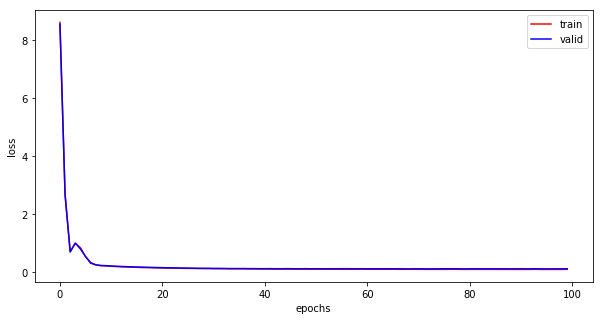

In [39]:
# 可以调整的超参
batch_size = 128
epochs = 100
lr = 0.01
wd = 0
use_gpu = True

net = get_model()
%time
train_model(net, train_features, train_labels, valid_features, valid_labels, epochs, 
            batch_size, lr, wd, use_gpu)

当我们构建好了训练的过程，下面就开始了不断地调参尝试，最后得到一个效果最好的模型

epoch: 10, train rmse: 0.141

epoch: 20, train rmse: 0.116

epoch: 30, train rmse: 0.106

epoch: 40, train rmse: 0.102

epoch: 50, train rmse: 0.099

epoch: 60, train rmse: 0.098

epoch: 70, train rmse: 0.097

epoch: 80, train rmse: 0.096

epoch: 90, train rmse: 0.095

epoch: 100, train rmse: 0.095



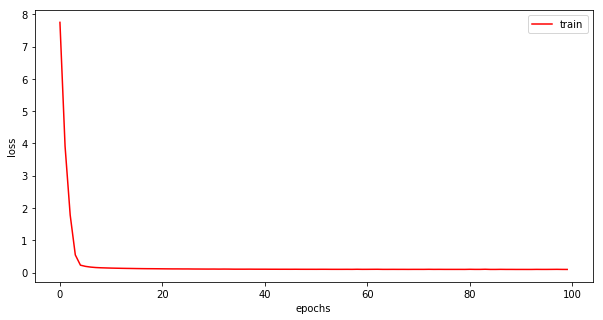

In [40]:
net = get_model()
train_model(net, train_valid_features, train_valid_labels, None, None, epochs, 
            batch_size, lr, wd, use_gpu)

运行下面的代码，可以通过训练好的模型预测 testset 的结果，会在当前目录生成 `submission.csv` 用于提交

In [41]:
pred(net, test, test_features)